In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# colab pro 더 빠른 GPU 사용
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov 16 04:47:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# colab pro 추가 메모리
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
# nltk에서 stopwords 다운로드
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import re
import numpy as np
import pandas as pd
import time
#import pyLDAvis
#import pyLDAvis.gensim_models
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from matplotlib import pyplot as plt

import gensim
import string
from gensim import corpora
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import multiprocessing
num_cores = multiprocessing.cpu_count()

# Change this to where your datasets are located:
os.chdir("/content/drive/MyDrive/Colab Notebooks/Aiffel_Hackathon/financial_documents/training_gold_standards") # 현재 디렉토리 설정. 잘못 건드리면 open에서 문제생길 수 있음.

## 확인 필요. 문제 없으면 지울 수 있음. ##
# Check versions to ensure that there are no compatability issues:
python_version = !python --version
print("Python Version: ", python_version)
print("Current Directory: ", os.getcwd())
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)

Python Version:  ['Python 3.7.12']
Current Directory:  /content/drive/.shortcut-targets-by-id/1w4WyhAQ16CIFKNbtXntCgKMZoYxIpzws/Aiffel_Hackathon/financial_documents/training_gold_standards
Numpy version:  1.19.5
Pandas version:  1.1.5


## Gold Standard Summary
training section과 비교할 수 있는 데이터를 분석합니다.

In [157]:
gold_standard_summary_report_path = '/content/drive/MyDrive/Colab Notebooks/Aiffel_Hackathon//gold_standard_summary_report.csv'
gs_df = pd.read_csv(gold_standard_summary_report_path)
gs_df

,Unnamed: 0,Original_Filename,Document,Middle,Section,Length
0,0,19468_698370_8,19468,698370,8,811
1,1,19471_701669_8,19471,701669,8,441
2,2,19480_703748_8,19480,703748,8,236
3,3,19471_701677_1,19471,701677,1,1714
4,4,19480_703751_1,19480,703751,1,1031
...,...,...,...,...,...,...
6782,6782,2584_148284_1,2584,148284,1,606
6783,6783,2584_148283_8,2584,148283,8,230
6784,6784,2586_148339_1,2586,148339,1,561
6785,6785,2586_148338_8,2586,148338,8,781


In [158]:
gs_df

,Unnamed: 0,Original_Filename,Document,Middle,Section,Length
0,0,19468_698370_8,19468,698370,8,811
1,1,19471_701669_8,19471,701669,8,441
2,2,19480_703748_8,19480,703748,8,236
3,3,19471_701677_1,19471,701677,1,1714
4,4,19480_703751_1,19480,703751,1,1031
...,...,...,...,...,...,...
6782,6782,2584_148284_1,2584,148284,1,606
6783,6783,2584_148283_8,2584,148283,8,230
6784,6784,2586_148339_1,2586,148339,1,561
6785,6785,2586_148338_8,2586,148338,8,781


In [159]:
gs_df = pd.DataFrame({'Original_Filename_y': gs_df['Original_Filename'],
                                    'Document': gs_df['Document'],
                                    'Middle': gs_df['Middle'],
                                    'Section': gs_df['Section'],
                                    'Length': gs_df['Length']})

In [160]:
gs_df

,Original_Filename_y,Document,Middle,Section,Length
0,19468_698370_8,19468,698370,8,811
1,19471_701669_8,19471,701669,8,441
2,19480_703748_8,19480,703748,8,236
3,19471_701677_1,19471,701677,1,1714
4,19480_703751_1,19480,703751,1,1031
...,...,...,...,...,...
6782,2584_148284_1,2584,148284,1,606
6783,2584_148283_8,2584,148283,8,230
6784,2586_148339_1,2586,148339,1,561
6785,2586_148338_8,2586,148338,8,781


### Gold Standard Summary
Each document has 1 gold standard summary for section 1 (3,000 total)  
##왜 1 선택했는지 논리 구조 짤 것##

In [162]:
gs_df = gs_df[gs_df['Section'] == 1]
gs_df

,Original_Filename_y,Document,Middle,Section,Length
3,19471_701677_1,19471,701677,1,1714
4,19480_703751_1,19480,703751,1,1031
7,19483_705473_1,19483,705473,1,1015
9,19484_706125_1,19484,706125,1,869
11,19485_706628_1,19485,706628,1,1262
...,...,...,...,...,...
6779,2583_148258_1,2583,148258,1,634
6780,2585_148311_1,2585,148311,1,810
6782,2584_148284_1,2584,148284,1,606
6784,2586_148339_1,2586,148339,1,561


In [163]:
# training_full_texts = os.listdir("/content/drive/MyDrive/Colab Notebooks/Aiffel_Hackathon/financial_documents/training_full_text")
# len(training_full_texts)
# # training_full_texts

### Training Sections
Analyze the Training Data Sections - similar to above

In [164]:
# # 10분 정도 걸림
# train_list = os.listdir("/content/drive/MyDrive/Colab Notebooks/Aiffel_Hackathon/financial_documents/training_sections")
# len(train_list)
# train_df = pd.DataFrame(train_list, columns=['Original_Filename'])
# train_df['Original_Filename'] = train_df['Original_Filename'].str.replace('.txt', '')
# train_df[['Document', 'Middle', 'Section']] = train_df['Original_Filename'].str.split('_').tolist()

# # os.chdir("/content/drive/MyDrive/Colab Notebooks/Aiffel_Hackathon/financial_documents/training_sections")
# # train_doc_lengths = []
# # for path in train_list:
# #     file = open(path, encoding='utf8')
# #     text = file.read()
# #     temp_length = len(text.split())
# #     train_doc_lengths.append(temp_length)
# #     file.close()
# # train_df['Length'] = train_doc_lengths

# # train_df.to_csv("/content/drive/MyDrive/Colab Notebooks/Aiffel_Hackathon/Training_Sections_Summary.csv")
# # train_df

In [165]:
train_df_path = "/content/drive/MyDrive/Colab Notebooks/Aiffel_Hackathon/Training_Sections_Summary.csv"
train_df = pd.read_csv(train_df_path)
train_df

,Unnamed: 0,Original_Filename,Document,Middle,Section,Length
0,0,15710_816683_2,15710,816683,2,1237
1,1,15840_820946_2,15840,820946,2,1829
2,2,15839_820917_2,15839,820917,2,830
3,3,15777_818852_2,15777,818852,2,1247
4,4,15778_818875_2,15778,818875,2,980
...,...,...,...,...,...,...
3081,3081,557_28822_2,557,28822,2,1720
3082,3082,590_29525_2,590,29525,2,2662
3083,3083,614_34076_2,614,34076,2,2852
3084,3084,615_34118_2,615,34118,2,330


In [166]:
train_df = train_df.drop(['Unnamed: 0'], axis=1)

In [167]:
train_df

,Original_Filename,Document,Middle,Section,Length
0,15710_816683_2,15710,816683,2,1237
1,15840_820946_2,15840,820946,2,1829
2,15839_820917_2,15839,820917,2,830
3,15777_818852_2,15777,818852,2,1247
4,15778_818875_2,15778,818875,2,980
...,...,...,...,...,...
3081,557_28822_2,557,28822,2,1720
3082,590_29525_2,590,29525,2,2662
3083,614_34076_2,614,34076,2,2852
3084,615_34118_2,615,34118,2,330


In [168]:
train_df.sort_values(by=['Document'], ascending=[True], inplace=True)
train_df.head(20)

,Original_Filename,Document,Middle,Section,Length
3000,17_896314_2,17,896314,2,1234
3001,19_896332_2,19,896332,2,1610
3004,64_868733_2,64,868733,2,976
3005,65_868749_2,65,868749,2,1518
3002,66_868765_2,66,868765,2,572
3006,67_868784_2,67,868784,2,1286
3008,72_3048_2,72,3048,2,3048
3009,73_3070_2,73,3070,2,4098
3007,92_840613_2,92,840613,2,716
3010,93_840633_2,93,840633,2,2268


중복되는 데이터를 제거합니다. (데이터셋을 섹션으로 나누어 놓았는데 같은 섹션이 중복되기 때문에 삭제하는 것으로 예상됨)

In [169]:
# train_df.loc[train_df['Document'] == '148', :]

In [170]:
train_df = train_df.drop_duplicates(subset=['Document', 'Section'], keep='first')
train_df

,Original_Filename,Document,Middle,Section,Length
3000,17_896314_2,17,896314,2,1234
3001,19_896332_2,19,896332,2,1610
3004,64_868733_2,64,868733,2,976
3005,65_868749_2,65,868749,2,1518
3002,66_868765_2,66,868765,2,572
...,...,...,...,...,...
995,25039_401256_2,25039,401256,2,2978
996,25040_401290_2,25040,401290,2,2822
998,25080_406847_2,25080,406847,2,2878
999,25081_406864_2,25081,406864,2,2712


## Text Length Comparisons
Analyze the Text by word count to get some statistics.

count     3000.000000
mean      2043.287000
std       1479.632853
min          0.000000
25%       1145.750000
50%       1717.000000
75%       2547.500000
max      21742.000000
Name: Length, dtype: float64

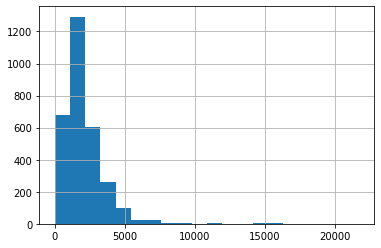

In [171]:
train_df['Length'].describe()
train_df['Length'].hist(bins=20)

In [172]:
over4000 = train_df[train_df['Length'] > 4000]
print(len(over4000))
print("ratio: ", len(over4000)/len(train_df['Length'])*100)

217
ratio:  7.233333333333333


In [173]:
over500 = 500 < train_df['Length']
less4000 = 4000 > train_df['Length']
new_train_df = train_df[over500 & less4000]
len(new_train_df)

2668

In [174]:
train_data = new_train_df.merge(gs_df, how='left', on=['Document'])
print(len(train_data))
train_data.head()

2668


,Original_Filename,Document,Middle_x,Section_x,Length_x,Original_Filename_y,Middle_y,Section_y,Length_y
0,17_896314_2,17,896314,2,1234,17_896313_1,896313,1,712
1,19_896332_2,19,896332,2,1610,19_896331_1,896331,1,777
2,64_868733_2,64,868733,2,976,64_868732_1,868732,1,478
3,65_868749_2,65,868749,2,1518,65_868748_1,868748,1,604
4,66_868765_2,66,868765,2,572,66_868764_1,868764,1,450


x = train_df  
y = gs_df 입니다.

### Appending the Data

In [175]:
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1w4WyhAQ16CIFKNbtXntCgKMZoYxIpzws/Aiffel_Hackathon/financial_documents/training_gold_standards'

In [176]:
train_data.rename(columns={'Original_Filename_y' : 'Gold_Filename',
                            'Section_y' : 'Gold Section',
                            'Length_y' : 'Gold_Summary_Length'}, inplace=True)
train_data.head()

,Original_Filename,Document,Middle_x,Section_x,Length_x,Gold_Filename,Middle_y,Gold Section,Gold_Summary_Length
0,17_896314_2,17,896314,2,1234,17_896313_1,896313,1,712
1,19_896332_2,19,896332,2,1610,19_896331_1,896331,1,777
2,64_868733_2,64,868733,2,976,64_868732_1,868732,1,478
3,65_868749_2,65,868749,2,1518,65_868748_1,868748,1,604
4,66_868765_2,66,868765,2,572,66_868764_1,868764,1,450


In [131]:
training_file_list = [x + str(".txt") for x in train_data['Original_Filename']]
training_file_list[:5]

['17_896314_2.txt',
 '19_896332_2.txt',
 '64_868733_2.txt',
 '65_868749_2.txt',
 '66_868765_2.txt',
 '67_868784_2.txt',
 '72_3048_2.txt',
 '92_840613_2.txt',
 '93_840633_2.txt',
 '102_4107_2.txt',
 '104_4147_2.txt',
 '105_4169_2.txt',
 '106_4189_2.txt',
 '108_4389_2.txt',
 '109_4414_2.txt',
 '110_4436_2.txt',
 '111_4458_2.txt',
 '118_25649_2.txt',
 '128_4978_2.txt',
 '129_4994_2.txt',
 '130_5009_2.txt',
 '131_5025_2.txt',
 '132_5049_2.txt',
 '149_6188_2.txt',
 '150_6208_2.txt',
 '151_6232_2.txt',
 '152_6251_2.txt',
 '153_6274_2.txt',
 '155_6322_2.txt',
 '156_6347_2.txt',
 '159_23656_2.txt',
 '160_23685_2.txt',
 '161_23714_2.txt',
 '163_12319_2.txt',
 '168_12435_2.txt',
 '169_12459_2.txt',
 '170_12482_2.txt',
 '174_12586_2.txt',
 '181_12887_2.txt',
 '205_13444_2.txt',
 '206_13458_2.txt',
 '214_13850_2.txt',
 '225_14279_2.txt',
 '227_14664_2.txt',
 '228_14680_2.txt',
 '229_14701_2.txt',
 '230_14716_2.txt',
 '231_14733_2.txt',
 '232_14750_2.txt',
 '233_14766_2.txt',
 '234_14782_2.txt',
 '

In [134]:
training_path = '/content/drive/MyDrive/Colab Notebooks/Aiffel_Hackathon/financial_documents/training_sections/'

sentence_list = []

for i in training_file_list:
  temp_str = ''
  with open(training_path + i, "r", encoding='utf-8') as f:
    for line in f:
      # 끝에는 띄어쓰기로 치환. 두번 나와도 나중에 정규식으로 제거하면 됨.
      line = line.replace('\n', ' ')
      temp_str += line
    sentence_list.append(temp_str)

In [136]:
len(sentence_list)

2668

In [142]:
sentence_list[:2]

['  06 Z GROUP plc  ANNUAL REPORT AND ACCOUNTS 2006 JOINT CHIEF EXECUTIVES’ STATEMENT JAMIE TRUE Joint Chief Executive JACK BEKHOR Joint Chief Executive “ This year has seen us achieve not only admission to AIM  but also a 78% increase in our proﬁ ts, with a pre-tax proﬁ t  of £1.1 million.” OVERVIEW This is our ﬁ rst Annual Report since joining AIM and we are  pleased to announce that we have achieved further  improvement in our proﬁ ts this year, our third consecutive  year of growth, with a pre-tax proﬁ t of £1.1 million. This  success has been the result of consolidating our core  business, developing new delivery channels and expanding  into European and other international markets. We have  also made signiﬁ cant investment in our product portfolio,  both by licensing new technologies to commercialise  and by developing in-house proprietary technologies to  address the needs of mass consumer markets. AIMS AND ACHIEVEMENTS Our primary aim this year was to increase our turnover  and

In [180]:
train_data['Full_Text'] = sentence_list
train_data.head(5)

,Original_Filename,Document,Middle_x,Section_x,Length_x,Gold_Filename,Middle_y,Gold Section,Gold_Summary_Length,Full_Text
0,17_896314_2,17,896314,2,1234,17_896313_1,896313,1,712,06 Z GROUP plc ANNUAL REPORT AND ACCOUNTS 2...
1,19_896332_2,19,896332,2,1610,19_896331_1,896331,1,777,JOiNT CHiEf EXECUTivES’ ST aTEmENT iNTrOdUCTi...
2,64_868733_2,64,868733,2,976,64_868732_1,868732,1,478,VPhase plc Group Financial Statements for t...
3,65_868749_2,65,868749,2,1518,65_868748_1,868748,1,604,6 VPhase plc Group Financial Statements for t...
4,66_868765_2,66,868765,2,572,66_868764_1,868764,1,450,3 w w w . vph a s e . c o . u k \t V Ph as e ...


In [181]:
train_data["Length_Full_Text"] = train_data['Full_Text'].str.split().str.len()
train_data.head()

,Original_Filename,Document,Middle_x,Section_x,Length_x,Gold_Filename,Middle_y,Gold Section,Gold_Summary_Length,Full_Text,Length_Full_Text
0,17_896314_2,17,896314,2,1234,17_896313_1,896313,1,712,06 Z GROUP plc ANNUAL REPORT AND ACCOUNTS 2...,1234
1,19_896332_2,19,896332,2,1610,19_896331_1,896331,1,777,JOiNT CHiEf EXECUTivES’ ST aTEmENT iNTrOdUCTi...,1610
2,64_868733_2,64,868733,2,976,64_868732_1,868732,1,478,VPhase plc Group Financial Statements for t...,976
3,65_868749_2,65,868749,2,1518,65_868748_1,868748,1,604,6 VPhase plc Group Financial Statements for t...,1518
4,66_868765_2,66,868765,2,572,66_868764_1,868764,1,450,3 w w w . vph a s e . c o . u k \t V Ph as e ...,572


In [182]:
summary_file_list = [x+str(".txt") for x in train_data['Gold_Filename']]
length_list = train_data['Length_Full_Text'].tolist()

In [185]:
summary_file_list[:5]

['17_896313_1.txt',
 '19_896331_1.txt',
 '64_868732_1.txt',
 '65_868748_1.txt',
 '66_868764_1.txt']

In [197]:
gold_path = '/content/drive/MyDrive/Colab Notebooks/Aiffel_Hackathon/financial_documents/training_gold_standards/'

gold_sentence_list = []

for i in summary_file_list:
  temp_str2 = ''
  with open(gold_path + i, "r", encoding='utf-8') as f:
    for line in f:
      # 끝에는 띄어쓰기로 치환. 두번 나와도 나중에 정규식으로 제거하면 됨.
      line = line.replace('\n', ' ')
      temp_str2 += line
    gold_sentence_list.append(temp_str2)

In [198]:
gold_sentence_list[0]
print('\n')
len(gold_sentence_list)

'  04 CHAIRMAN’S STATEMENT JOHN STANDEN Non-Executive Chairman  “ We ended the year with a clear focus for the future  – to continue to invest in new licensed technologies  and to continue to create our own Intellectual Property.” I am pleased to report our ﬁ rst full ﬁ nancial results since  Z GROUP’s successful admission to trading on the  London Stock Exchange’s Alternative Investment Market  in June 2005.  RESULTS Our results demonstrate that our business model is delivering  substantial growth. Turnover has increased by 63% to  £5.0 million compared with £3.1 million for the 11-month period  ended 28 February 2005, as annualised for comparison  purposes. Gross margin was consistent with previous  periods of trading at 78% and we made a record full year  pre-tax proﬁ t of £1.1 million (2005: £0.6 million). After a substantial investment of £0.9 million in our new  products and the related websites, we ended the year with  cash resources of £4.1 million, compared to £4.6 million  im

2668

In [200]:
train_data['Summary_Text'] = gold_sentence_list
train_data.head()

,Original_Filename,Document,Middle_x,Section_x,Length_x,Gold_Filename,Middle_y,Gold Section,Gold_Summary_Length,Full_Text,Length_Full_Text,Summary_Text
0,17_896314_2,17,896314,2,1234,17_896313_1,896313,1,712,06 Z GROUP plc ANNUAL REPORT AND ACCOUNTS 2...,1234,04 CHAIRMAN’S STATEMENT JOHN STANDEN Non-Exe...
1,19_896332_2,19,896332,2,1610,19_896331_1,896331,1,777,JOiNT CHiEf EXECUTivES’ ST aTEmENT iNTrOdUCTi...,1610,“godsend” “ Your service has been a godsend f...
2,64_868733_2,64,868733,2,976,64_868732_1,868732,1,478,VPhase plc Group Financial Statements for t...,976,VPhase plc Group Financial Statements for t...
3,65_868749_2,65,868749,2,1518,65_868748_1,868748,1,604,6 VPhase plc Group Financial Statements for t...,1518,4 VPhase plc Group Financial Statements for t...
4,66_868765_2,66,868765,2,572,66_868764_1,868764,1,450,3 w w w . vph a s e . c o . u k \t V Ph as e ...,572,2 V Ph as e plc Group Financial Statements f...


In [203]:
train_data.set_index(['Original_Filename', 'Gold_Filename'], inplace=True)
train_data_2 = train_data[['Document', 'Full_Text', 'Summary_Text']]
train_data_2

,,Document,Full_Text,Summary_Text
Original_Filename,Gold_Filename,,,
17_896314_2,17_896313_1,17,06 Z GROUP plc ANNUAL REPORT AND ACCOUNTS 2...,04 CHAIRMAN’S STATEMENT JOHN STANDEN Non-Exe...
19_896332_2,19_896331_1,19,JOiNT CHiEf EXECUTivES’ ST aTEmENT iNTrOdUCTi...,“godsend” “ Your service has been a godsend f...
64_868733_2,64_868732_1,64,VPhase plc Group Financial Statements for t...,VPhase plc Group Financial Statements for t...
65_868749_2,65_868748_1,65,6 VPhase plc Group Financial Statements for t...,4 VPhase plc Group Financial Statements for t...
66_868765_2,66_868764_1,66,3 w w w . vph a s e . c o . u k \t V Ph as e ...,2 V Ph as e plc Group Financial Statements f...
...,...,...,...,...
25039_401256_2,25039_401255_1,25039,CHIEF EXECUTIVE OFFICER’S REVIEW ‘2015 was a...,CHAIRMAN’S STATEMENT This is my first oppor...
25040_401290_2,25040_401289_1,25040,CHIEF EXECUTIVE OFFICER’S REVIEW This is my f...,CHAIRMAN’S STATEMENT In my second annual stat...
25080_406847_2,25080_406846_1,25080,Impax Asset Management Group plc (formerly Im...,Impax Asset Management Group plc (formerly Im...


In [204]:
train_data_2.to_csv("/content/drive/MyDrive/Colab Notebooks/Aiffel_Hackathon/financial_documents/preprocessing_test/Training_Data_uncleaned.csv")

## Load the Data for Cleaning

In [215]:
uncleaned_data_path = "/content/drive/MyDrive/Colab Notebooks/Aiffel_Hackathon/financial_documents/preprocessing_test/Training_Data_uncleaned.csv"
train_data3 = pd.read_csv(uncleaned_data_path)
train_data3.head()

,Original_Filename,Gold_Filename,Document,Full_Text,Summary_Text
0,17_896314_2,17_896313_1,17,06 Z GROUP plc ANNUAL REPORT AND ACCOUNTS 2...,04 CHAIRMAN’S STATEMENT JOHN STANDEN Non-Exe...
1,19_896332_2,19_896331_1,19,JOiNT CHiEf EXECUTivES’ ST aTEmENT iNTrOdUCTi...,“godsend” “ Your service has been a godsend f...
2,64_868733_2,64_868732_1,64,VPhase plc Group Financial Statements for t...,VPhase plc Group Financial Statements for t...
3,65_868749_2,65_868748_1,65,6 VPhase plc Group Financial Statements for t...,4 VPhase plc Group Financial Statements for t...
4,66_868765_2,66_868764_1,66,3 w w w . vph a s e . c o . u k \t V Ph as e ...,2 V Ph as e plc Group Financial Statements f...


In [206]:
# Function to remove non-ascii characters from the text

def remove_non_ascii(text_list):
  clean_list = []
  for text in text_list:
    try:
      temp_encode = text.encode('ascii', 'ignore')
      temp_decode = temp_encode.decode('ascii')
    except:
      continue
    finally:
      clean_list.append(temp_decode)
  return clean_list

In [207]:
unclean_full_text = list(train_data['Full_Text'])
clean_full_text = remove_non_ascii(unclean_full_text)
clean_full_text[0]

'  06 Z GROUP plc  ANNUAL REPORT AND ACCOUNTS 2006 JOINT CHIEF EXECUTIVES STATEMENT JAMIE TRUE Joint Chief Executive JACK BEKHOR Joint Chief Executive  This year has seen us achieve not only admission to AIM  but also a 78% increase in our pro ts, with a pre-tax pro t  of 1.1 million. OVERVIEW This is our  rst Annual Report since joining AIM and we are  pleased to announce that we have achieved further  improvement in our pro ts this year, our third consecutive  year of growth, with a pre-tax pro t of 1.1 million. This  success has been the result of consolidating our core  business, developing new delivery channels and expanding  into European and other international markets. We have  also made signi cant investment in our product portfolio,  both by licensing new technologies to commercialise  and by developing in-house proprietary technologies to  address the needs of mass consumer markets. AIMS AND ACHIEVEMENTS Our primary aim this year was to increase our turnover  and profits whi

In [208]:
unclean_summary_text = list(train_data['Summary_Text'])
clean_summary_text = remove_non_ascii(unclean_summary_text)
clean_summary_text[0]

'  04 CHAIRMANS STATEMENT JOHN STANDEN Non-Executive Chairman   We ended the year with a clear focus for the future   to continue to invest in new licensed technologies  and to continue to create our own Intellectual Property. I am pleased to report our  rst full  nancial results since  Z GROUPs successful admission to trading on the  London Stock Exchanges Alternative Investment Market  in June 2005.  RESULTS Our results demonstrate that our business model is delivering  substantial growth. Turnover has increased by 63% to  5.0 million compared with 3.1 million for the 11-month period  ended 28 February 2005, as annualised for comparison  purposes. Gross margin was consistent with previous  periods of trading at 78% and we made a record full year  pre-tax pro t of 1.1 million (2005: 0.6 million). After a substantial investment of 0.9 million in our new  products and the related websites, we ended the year with  cash resources of 4.1 million, compared to 4.6 million  immediately follow

In [219]:
# 정규표현식 실험
re.sub('\s\s', ' ', clean_full_text[0])

' 06 Z GROUP plc ANNUAL REPORT AND ACCOUNTS 2006 JOINT CHIEF EXECUTIVES STATEMENT JAMIE TRUE Joint Chief Executive JACK BEKHOR Joint Chief Executive This year has seen us achieve not only admission to AIM but also a 78% increase in our pro ts, with a pre-tax pro t of 1.1 million. OVERVIEW This is our rst Annual Report since joining AIM and we are pleased to announce that we have achieved further improvement in our pro ts this year, our third consecutive year of growth, with a pre-tax pro t of 1.1 million. This success has been the result of consolidating our core business, developing new delivery channels and expanding into European and other international markets. We have also made signi cant investment in our product portfolio, both by licensing new technologies to commercialise and by developing in-house proprietary technologies to address the needs of mass consumer markets. AIMS AND ACHIEVEMENTS Our primary aim this year was to increase our turnover and profits whilst investing in 

In [221]:
## \s\s (스페이스) 두번 된 텍스트 전처리

for i in range(len(train_data['Full_Text'])):
  src_sen = re.sub('\s\s', ' ', train_data3['Full_Text'][i])
  train_data3['Full_Text'][i] = src_sen

  tgt_sen = re.sub('\s\s', ' ', train_data3['Summary_Text'][i])
  train_data3['Summary_Text'][i] = tgt_sen

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [224]:
train_data3['Full_Text'][2]

' VPhase plc  Group Financial Statements for the year ended 31 December 2008 05 Chief Executive’s Review I am delighted to report that the Group has successfully delivered its key objective of positioning its first product VX1 to be ready for the next stage of commercialisation in 2009 and to place VX1 in an Ofgem Demonstration Action programme. This programme has been fully funded by SSE to a value of up to £240,000, and it is anticipated that these trials of VX1 will demonstrate significant carbon dioxide savings when used in UK domestic properties. Additionally, the Group is starting a programme of commercial partnerships to introduce VPhase initially to European and then to other geographic markets. We have already entered into a memorandum of understanding with British Gas to consider routes to market for VPhase products in the UK and also into North America through Direct Energy, one of America’s leading integrated energy companies and another Centrica-owned business. We have als

In [ ]:
# train_data.rename(columns={'Full_Text': 'input_text', 'Summary_Text':'target_text'}, inplace=True)
# train_data.head(10)

In [225]:
train_data3.head()

,Original_Filename,Gold_Filename,Document,Full_Text,Summary_Text
0,17_896314_2,17_896313_1,17,06 Z GROUP plc ANNUAL REPORT AND ACCOUNTS 200...,04 CHAIRMAN’S STATEMENT JOHN STANDEN Non-Exec...
1,19_896332_2,19_896331_1,19,JOiNT CHiEf EXECUTivES’ ST aTEmENT iNTrOdUCTi...,“godsend” “ Your service has been a godsend f...
2,64_868733_2,64_868732_1,64,VPhase plc Group Financial Statements for th...,VPhase plc Group Financial Statements for th...
3,65_868749_2,65_868748_1,65,6 VPhase plc Group Financial Statements for t...,4 VPhase plc Group Financial Statements for t...
4,66_868765_2,66_868764_1,66,3 w w w . vph a s e . c o . u k V Ph as e pl...,2 V Ph as e plc Group Financial Statements fo...


In [227]:
train_data3.to_csv("/content/drive/MyDrive/Colab Notebooks/Aiffel_Hackathon/financial_documents/preprocessing_test/Training_Data_cleaned.csv")